<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/373_SAM_based_ASTM_Grain_Size_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://youtu.be/KCGKLh05HRM

# SAM-based ASTM Grain Size Analysis

This code takes an input microscope image with grains and performs comprehensive grain analysis, including automated segmentation and ASTM E112 compliance reporting.

## Workflow Overview

### 1. Image Preprocessing
- Loads microstructure images (RGB or grayscale)
- Converts to appropriate formats for different analysis stages
- Applies contrast enhancement if needed for difficult boundaries

### 2. Initial Grain Detection (U-Net)
- Uses a pre-trained U-Net model to identify potential grain regions
- Generates probability maps showing grain vs. boundary likelihood
- Extracts seed coordinates (grain centers) using DBSCAN clustering
- Provides initial grain location estimates for refinement

### 3. Precise Grain Segmentation (SAM)
- Loads Meta's Segment Anything Model (SAM) for high-precision segmentation
- Uses U-Net seed points as prompts for SAM
- SAM generates precise grain boundaries with confidence scores
- Creates labeled grain map with individual grain IDs
- Falls back to enhanced watershed segmentation if SAM fails

### 4. Grain Property Analysis
- Calculates morphological properties for each detected grain:
  - Area, perimeter, equivalent circular diameter (ECD)
  - Aspect ratio, circularity, orientation
  - Centroid coordinates and bounding box
- Converts pixel measurements to physical units (μm)
- Removes statistical outliers using IQR method


### 6. ASTM E112 Calculations
- Implements ASTM E112 standard for grain size measurement: [Link](https://www.fushunspecialsteel.com/wp-content/uploads/2015/09/ASTM-E112-2010-Standard-Test-Methods-for-Determining-Average-Grain-Size.pdf)
- Uses **planimetric method** (Method 2) based on mean grain area
- Calculates equivalent circular diameter (ECD) for each grain
- Computes grain size number (G) using area-based formula
- Accounts for actual image scale rather than traditional magnification assumptions
- Provides grain size classification (Very Fine to Very Coarse)


### 8. Reporting
- Generates multiple visualization formats:
  - Original vs. segmented images
  - Grains colored by size (full grain coloring)
  - Size distribution histograms and cumulative plots
  - ASTM standard comparison charts
- Creates HTML report with detailed statistics and methodology notes
- Exports CSV files with individual grain measurements



## Technical Notes

- **GPU Acceleration**: SAM benefits significantly from GPU processing
- **Scale Calibration**: Requires accurate μm/pixel calibration from microscope
- **Model Dependencies**: Requires pre-trained U-Net and SAM models
- **Memory Requirements**: Large images may require batch processing for SAM

This workflow provides publication-ready grain size analysis suitable for materials characterization and quality control applications.

In [ ]:
!pip install segmenteverygrain rtree   #segmenteverygrain uses rtree - for spatial indexing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 114.5 MB/s eta 0:00:00


In [ ]:
#Download Unet model from here
# !wget https://github.com/zsylvester/segmenteverygrain/blob/main/models/seg_model.keras -O /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/seg_model.keras


In [ ]:
# Download a lightweight SAM model
# !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth -O /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/sam_vit_b_01ec64.pth

In [ ]:
# =============================================================================
# SECTION 1: SETUP AND IMPORTS
# =============================================================================

# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pandas as pd
from scipy import ndimage
from skimage import measure
import os
from pathlib import Path

# SAM and segmenteverygrain
import segmenteverygrain as seg
from keras.utils import load_img
from segment_anything import sam_model_registry, SamPredictor
from tqdm import tqdm

# Configuration
MODEL_PATHS = {
    'unet': "/content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/seg_model.keras",
    'sam': "/content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/sam_vit_b_01ec64.pth"
}

IMAGE_PATH = "/content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/microstructure.png" # microstructure.png, synthetic_grains.png
OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results"
SCALE_UM_PER_PIXEL = 0.25  # Adjust based on your microscope settings
MIN_GRAIN_AREA = 100      # Minimum grain area in pixels

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Output directory created: {OUTPUT_DIR}")
print(f"Analysis parameters:")
print(f"   - Scale: {SCALE_UM_PER_PIXEL} μm/pixel")
print(f"   - Minimum grain area: {MIN_GRAIN_AREA} pixels")
print()

Output directory created: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results
Analysis parameters:
   - Scale: 0.25 μm/pixel
   - Minimum grain area: 100 pixels



Section 2: Loading and preprocessing the microstructure image

Loading image: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/microstructure.png
Original image shape: (680, 850, 3)
Converted to grayscale: (680, 850)


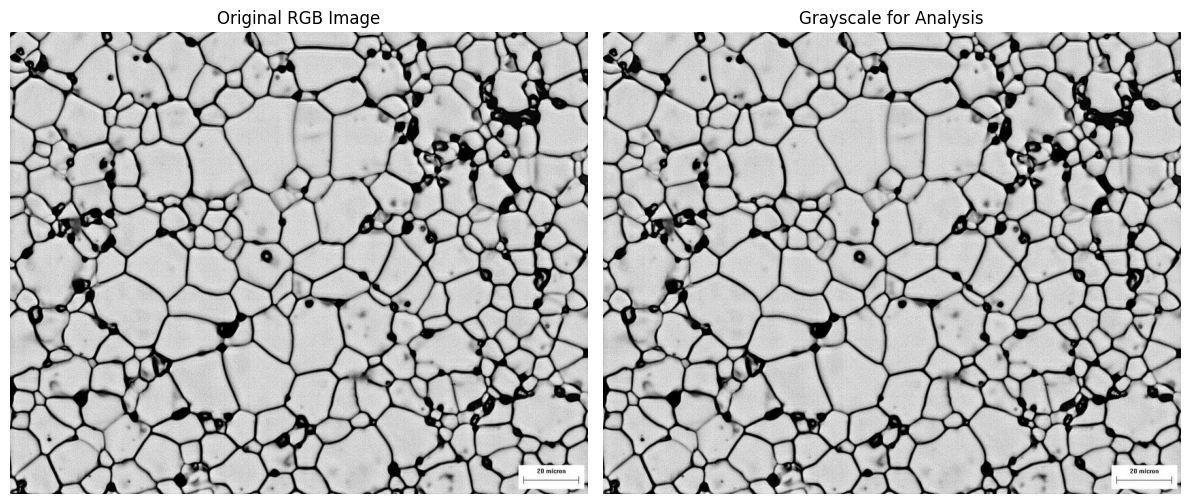

Results saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/01_original_image.png



In [ ]:
# =============================================================================
# SECTION 2: IMAGE LOADING AND PREPROCESSING
# =============================================================================

print("="*60)
print("Section 2: Loading and preprocessing the microstructure image")
print()

def convert_to_grayscale(image):
    """Convert RGB image to grayscale"""
    if len(image.shape) == 3:
        if image.shape[2] == 3:  # RGB
            gray = 0.299 * image[:, :, 0] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 2]
            return gray.astype(np.uint8)
        elif image.shape[2] == 1:  # Single channel
            return image[:, :, 0]
        else:
            return image[:, :, 0]  # Take first channel
    else:
        return image  # Already 2D

# Load the microstructure image
print(f"Loading image: {IMAGE_PATH}")
original_image = np.array(load_img(IMAGE_PATH))
print(f"Original image shape: {original_image.shape}")

# Convert to grayscale for analysis (keep RGB for SAM)
if len(original_image.shape) == 3:
    gray_image = convert_to_grayscale(original_image)
    print(f"Converted to grayscale: {gray_image.shape}")
else:
    gray_image = original_image
    print("Image is already grayscale")

# Display the loaded image
plt.figure(figsize=(12, 5))
if len(original_image.shape) == 3:
    plt.subplot(1, 2, 1)
    plt.imshow(original_image)
    plt.title("Original RGB Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(gray_image, cmap='gray')
    plt.title("Grayscale for Analysis")
    plt.axis('off')
else:
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/01_original_image.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Results saved: {OUTPUT_DIR}/01_original_image.png")
print()

Section 3: U-Net based grain detection

Loading U-Net model...
U-Net model loaded successfully
Running U-Net prediction...
segmenting image tiles...


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


U-Net prediction complete, shape: (680, 850, 3)
Extracting potential grain locations...
Found 1025 potential grain locations


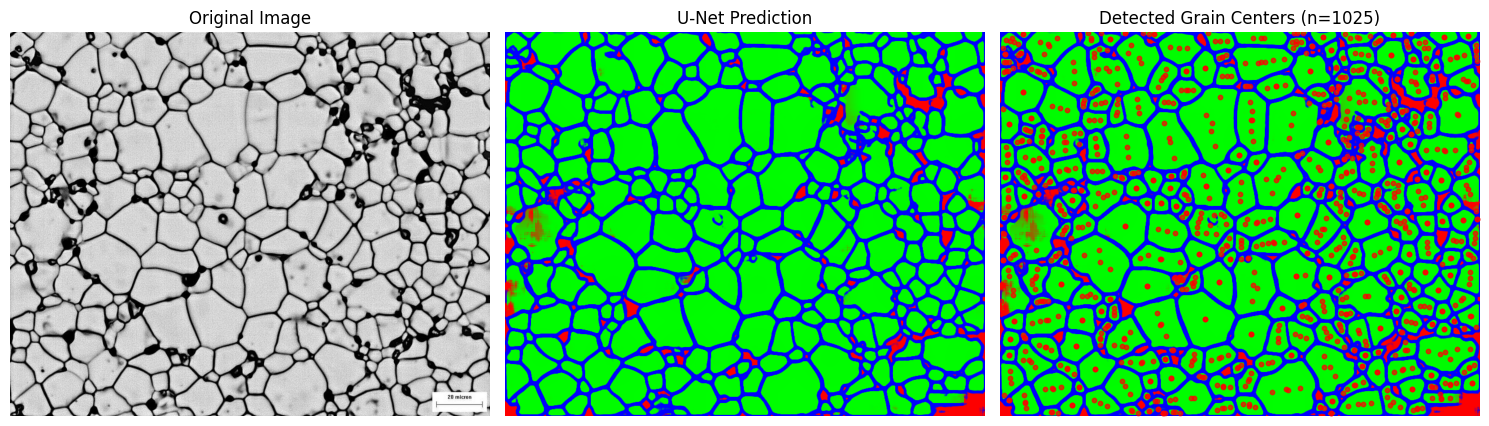

Results saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/02_unet_results.png



In [ ]:
# =============================================================================
# SECTION 3: U-NET GRAIN DETECTION (unet from segmenteverygrain - can be custom)
# =============================================================================

print("="*60)
print("Section 3: U-Net based grain detection")
print()

# Load the U-Net model
print("Loading U-Net model...")
try:
    unet_model = seg.load_model(
        MODEL_PATHS['unet'],
        custom_objects={'weighted_crossentropy': seg.weighted_crossentropy}
    )
    print("U-Net model loaded successfully")
except Exception as e:
    print(f"Error loading U-Net model: {e}")
    raise

# Run U-Net prediction
print("Running U-Net prediction...")
image_pred = seg.predict_image(original_image, unet_model, I=256)
print(f"U-Net prediction complete, shape: {image_pred.shape}")

# Extract grain coordinates
print("Extracting potential grain locations...")
labels_unet, coords = seg.label_grains(original_image, image_pred, dbs_max_dist=6.0)   #Original value 20 - adjust as needed
print(f"Found {len(coords)} potential grain locations")

# Visualize U-Net results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(image_pred, cmap='hot')
plt.title("U-Net Prediction")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_pred, cmap='gray')
if len(coords) > 0:
    coords_array = np.array(coords)
    plt.scatter(coords_array[:,0], coords_array[:,1], c='red', s=10, alpha=0.7)
plt.title(f"Detected Grain Centers (n={len(coords)})")
plt.axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/02_unet_results.png", dpi=300, bbox_inches='tight')
plt.show()


print(f"Results saved: {OUTPUT_DIR}/02_unet_results.png")
print()

Section 4: SAM-based grain boundary refinement

Loading SAM model...
GPU detected: Tesla T4
GPU memory: 14.7 GB
SAM model loaded successfully on cuda
GPU memory allocated: 0.35 GB
Processing 1025 coordinates with SAM...


SAM batch 21: 100%|██████████| 25/25 [00:00<00:00, 121.52it/s]


SAM generated 1024 valid masks from 1025 attempts
Created labeled image with 651 grains


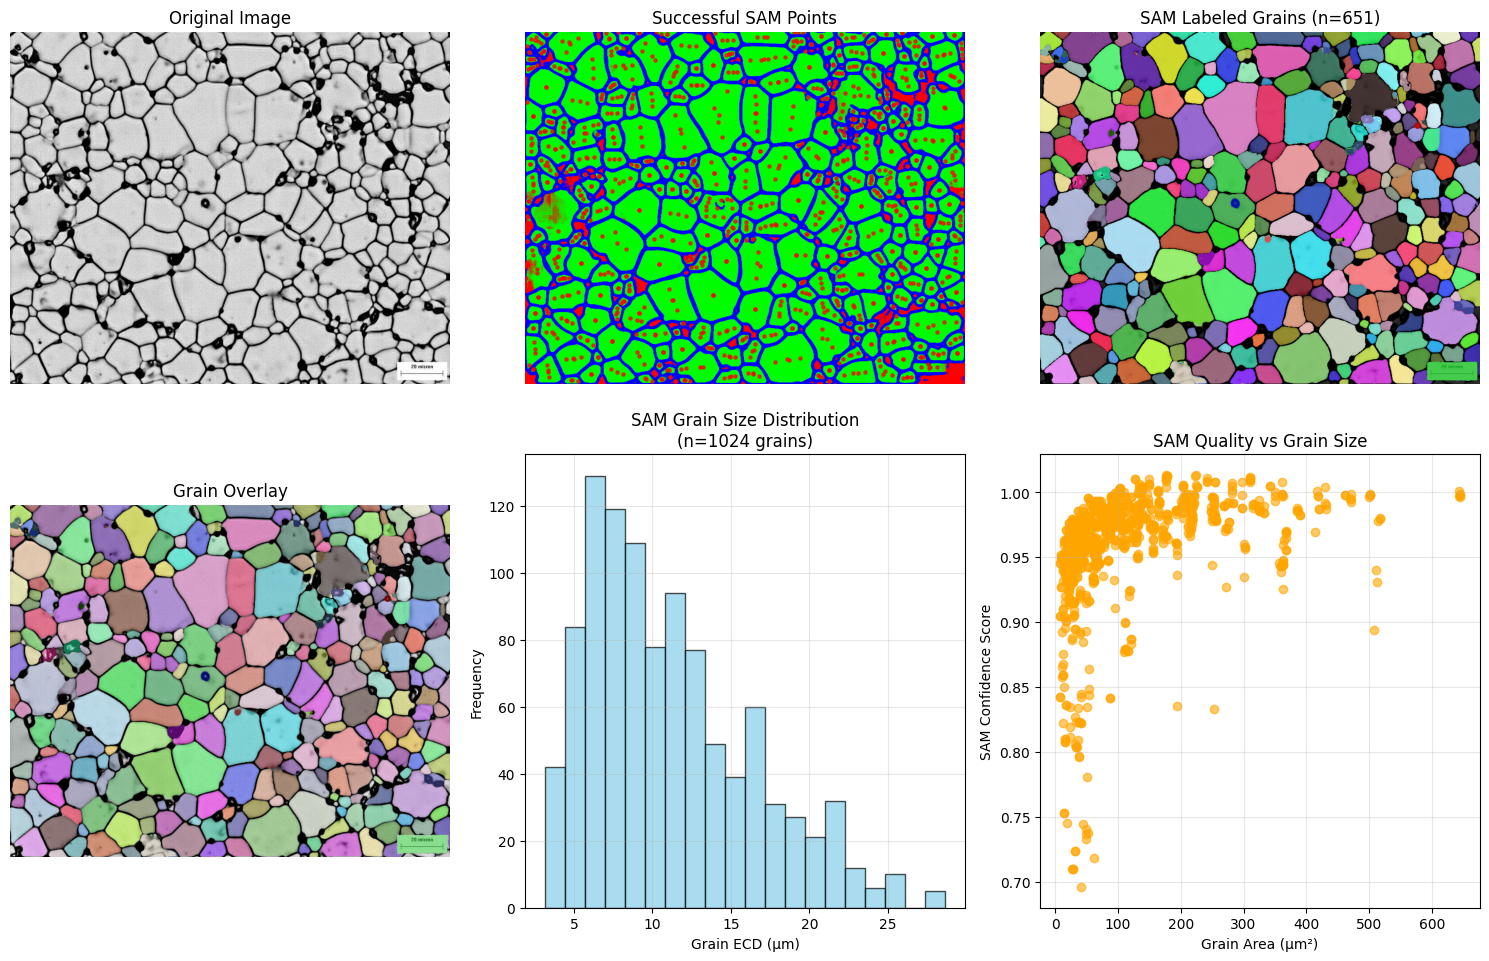

Results saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/03_sam_results.png
Labeled image saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/sam_labeled_image.npy



In [ ]:
# =============================================================================
# SECTION 4: SAM REFINEMENT
# =============================================================================

print("="*60)
print("Section 4: SAM-based grain boundary refinement")
print()

def robust_sam_segmentation(sam_model, image, coords, min_area=50):    #initial SAM attemp gave errors, so trying this enhanced method...

    predictor = SamPredictor(sam_model)
    predictor.set_image(image)

    all_masks = []
    all_scores = []
    successful_coords = []

    print(f"Processing {len(coords)} coordinates with SAM...")

    # Process in batches for better GPU utilization (optional optimization... added whn things got slow on my workstation)
    batch_size = 50  # Process 50 points at a time

    for batch_start in range(0, len(coords), batch_size):
        batch_end = min(batch_start + batch_size, len(coords))
        batch_coords = coords[batch_start:batch_end]

        for i, coord in enumerate(tqdm(batch_coords, desc=f"SAM batch {batch_start//batch_size + 1}")):
            try:
                # Handle both numpy arrays and lists/tuples .... added after a bit bug fixing...
                if isinstance(coord, np.ndarray):
                    if coord.shape == (2,):
                        x, y = int(coord[0]), int(coord[1])
                    else:
                        continue
                elif isinstance(coord, (list, tuple)) and len(coord) == 2:
                    x, y = int(coord[0]), int(coord[1])
                else:
                    continue

                # Validate coordinates are within image bounds .... not sure why i was getting a few out of bounds... fixed it though!!!
                if x < 0 or x >= image.shape[1] or y < 0 or y >= image.shape[0]:
                    continue

                point_coords = np.array([[x, y]])
                point_labels = np.array([1])

                masks, scores, logits = predictor.predict(
                    point_coords=point_coords,
                    point_labels=point_labels,
                    multimask_output=True,
                )

                # Take the best mask
                if len(masks) > 0 and len(scores) > 0:
                    best_idx = np.argmax(scores)
                    mask = masks[best_idx]
                    score = scores[best_idx]

                    if mask is not None and np.sum(mask) >= min_area:
                        all_masks.append(mask)
                        all_scores.append(score)
                        successful_coords.append([x, y])

            except Exception as e:
                continue

    return all_masks, all_scores, successful_coords

# Load SAM model with GPU support
print("Loading SAM model...")
try:
    import torch

    # Check for GPU availability
    if torch.cuda.is_available():
        device = "cuda"
        print(f"GPU detected: {torch.cuda.get_device_name(0)}")
        print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
    else:
        device = "cpu"
        print("No GPU detected, using CPU")

    sam_model = sam_model_registry["vit_b"](checkpoint=MODEL_PATHS['sam'])
    sam_model.to(device=device)
    print(f"SAM model loaded successfully on {device}")

    # Optional: Print memory usage
    if device == "cuda":
        print(f"GPU memory allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")

except Exception as e:
    print(f"Error loading SAM model: {e}")
    raise

# Run SAM segmentation
if len(coords) > 0:
    masks, scores, successful_coords = robust_sam_segmentation(
        sam_model, original_image, coords, min_area=MIN_GRAIN_AREA
    )
    print(f"SAM generated {len(masks)} valid masks from {len(coords)} attempts")
else:
    masks, scores, successful_coords = [], [], []
    print("No coordinates available for SAM processing")

# Create labeled image from SAM masks
def create_labeled_image_from_masks(masks, image_shape):
    """Create 2D labeled image from SAM masks"""
    if len(image_shape) == 3:
        labels = np.zeros(image_shape[:2], dtype=np.int32)
    else:
        labels = np.zeros(image_shape, dtype=np.int32)

    for i, mask in enumerate(masks):
        # Ensure mask is 2D
        if len(mask.shape) == 3:
            mask = mask[:, :, 0] if mask.shape[2] == 1 else np.any(mask, axis=2)

        # Avoid overlapping
        labels[mask & (labels == 0)] = i + 1

    return labels

if len(masks) > 0:
    sam_labels = create_labeled_image_from_masks(masks, original_image.shape)
    print(f"Created labeled image with {len(np.unique(sam_labels))-1} grains")
else:
    # Fallback to U-Net segmentation
    print("No SAM masks generated, using U-Net fallback...")
    binary_unet = image_pred > 0.5
    sam_labels, n_labels = ndimage.label(binary_unet)
    print(f"U-Net fallback: {n_labels} connected components found")

# Ensure labeled image is 2D
if len(sam_labels.shape) == 3:
    if sam_labels.shape[2] == 1:
        sam_labels = sam_labels[:, :, 0]
    else:
        sam_labels = np.max(sam_labels, axis=2)

# Visualize SAM results
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(gray_image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_pred, cmap='gray')
if len(successful_coords) > 0:
    coords_array = np.array(successful_coords)
    plt.scatter(coords_array[:,0], coords_array[:,1], c='red', s=5, alpha=0.7)
plt.title("Successful SAM Points")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(gray_image, cmap='gray')
# Create random colormap for better grain visualization
np.random.seed(42)  # For reproducible colors
n_grains = len(np.unique(sam_labels)) - 1  # Exclude background
random_colors = np.random.rand(n_grains + 1, 3)  # +1 for background
random_colors[0] = [0, 0, 0]  # Black background

# Create colored image
colored_grains = np.zeros((*sam_labels.shape, 3))
for grain_id in np.unique(sam_labels):
    if grain_id > 0:  # Skip background
        mask = sam_labels == grain_id
        colored_grains[mask] = random_colors[grain_id % len(random_colors)]

plt.imshow(colored_grains, alpha=0.8)
plt.title(f"SAM Labeled Grains (n={len(np.unique(sam_labels))-1})")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(gray_image, cmap='gray')

# Use the SAME random colors as the SAM Labeled Grains plot
# (Make sure this uses the same random seed and color generation)
np.random.seed(42)  # Same seed as before
n_grains = len(np.unique(sam_labels)) - 1  # Exclude background
random_colors = np.random.rand(n_grains + 1, 3)  # +1 for background
random_colors[0] = [0, 0, 0]  # Black background

# Create colored overlay with same colors
colored_overlay = np.zeros((*sam_labels.shape, 4))  # RGBA for transparency
for grain_id in np.unique(sam_labels):
    if grain_id > 0:  # Skip background
        mask = sam_labels == grain_id
        color = random_colors[grain_id % len(random_colors)]
        colored_overlay[mask] = [color[0], color[1], color[2], 0.5]  # 50% transparency

plt.imshow(colored_overlay)
plt.title("Grain Overlay")
plt.axis('off')


# Show grain size statistics (instead of individual grains)
if len(masks) >= 4:
    plt.subplot(2, 3, 5)
    # Calculate grain areas
    grain_areas = [np.sum(mask) * (SCALE_UM_PER_PIXEL ** 2) for mask in masks]
    grain_ecds = [2 * np.sqrt(area / np.pi) for area in grain_areas]

    plt.hist(grain_ecds, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Grain ECD (μm)')
    plt.ylabel('Frequency')
    plt.title(f'SAM Grain Size Distribution\n(n={len(masks)} grains)')
    plt.grid(True, alpha=0.3)

    plt.subplot(2, 3, 6)
    plt.scatter(grain_areas, scores, alpha=0.6, color='orange')
    plt.xlabel('Grain Area (μm²)')
    plt.ylabel('SAM Confidence Score')
    plt.title('SAM Quality vs Grain Size')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/03_sam_results.png", dpi=300, bbox_inches='tight')
plt.show()


print(f"Results saved: {OUTPUT_DIR}/03_sam_results.png")

# Save intermediate results
np.save(f"{OUTPUT_DIR}/sam_labeled_image.npy", sam_labels)
print(f"Labeled image saved: {OUTPUT_DIR}/sam_labeled_image.npy")
print()

In [ ]:
# =============================================================================
# SAVE INDIVIDUAL IMAGES FOR REPORT
# =============================================================================

print("Saving individual images for HTML report...")

# 1. Save original image only (single image, not side-by-side)
plt.figure(figsize=(8, 6))
if len(original_image.shape) == 3:
    plt.imshow(original_image)
else:
    plt.imshow(original_image, cmap='gray')
plt.title("Original Microstructure", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/original_single.png", dpi=150, bbox_inches='tight')
plt.close()

# 2. Save grain overlay only (just the colored grains on gray background)
plt.figure(figsize=(8, 6))
plt.imshow(gray_image, cmap='gray')

# Create random colormap for grain visualization (same as before)
np.random.seed(42)  # For reproducible colors
n_grains = len(np.unique(sam_labels)) - 1  # Exclude background
random_colors = np.random.rand(n_grains + 1, 3)  # +1 for background
random_colors[0] = [0, 0, 0]  # Black background

# Create colored overlay
colored_overlay = np.zeros((*sam_labels.shape, 4))  # RGBA for transparency
for grain_id in np.unique(sam_labels):
    if grain_id > 0:  # Skip background
        mask = sam_labels == grain_id
        color = random_colors[grain_id % len(random_colors)]
        colored_overlay[mask] = [color[0], color[1], color[2], 0.6]  # 60% transparency

plt.imshow(colored_overlay)
plt.title(f"Grain Segmentation Results (n={len(np.unique(sam_labels))-1})", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/grain_overlay_single.png", dpi=150, bbox_inches='tight')
plt.close()

# 3. Save simple size distribution (this will be created in the HTML function)
# We'll create this in the HTML report function as shown in the previous artifact

print("Individual images saved:")
print(f"   - {OUTPUT_DIR}/original_single.png")
print(f"   - {OUTPUT_DIR}/grain_overlay_single.png")
print(f"   - Size distribution will be created in HTML report")
print()

Saving individual images for HTML report...
Individual images saved:
   - /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/original_single.png
   - /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/grain_overlay_single.png
   - Size distribution will be created in HTML report



In [ ]:
# =============================================================================
# SECTION 5: GRAIN PROPERTY ANALYSIS
# =============================================================================

print("="*60)
print("Section 5: Grain property analysis")
print()

def analyze_grain_properties(labeled_image, scale_um_per_pixel):
    """Analyze grain properties for ASTM calculations"""

    # Ensure 2D labeled image
    if len(labeled_image.shape) == 3:
        print(f"Converting 3D labeled image {labeled_image.shape} to 2D")
        if labeled_image.shape[2] == 1:
            labeled_image = labeled_image[:, :, 0]
        else:
            unique_counts = [len(np.unique(labeled_image[:, :, i])) for i in range(labeled_image.shape[2])]
            best_channel = np.argmax(unique_counts)
            labeled_image = labeled_image[:, :, best_channel]

    print(f"Analyzing labeled image shape: {labeled_image.shape}")
    print(f"Unique labels: {len(np.unique(labeled_image))} (including background)")

    # Get region properties
    regions = measure.regionprops(labeled_image.astype(np.int32))

    grain_data = []

    for region in regions:
        if region.area < 10:  # Skip tiny regions
            continue

        # Calculate measurements
        area_pixels = region.area
        area_um2 = area_pixels * (scale_um_per_pixel ** 2)

        # Equivalent circular diameter (ECD) - key for ASTM
        ecd_pixels = 2 * np.sqrt(area_pixels / np.pi)
        ecd_um = ecd_pixels * scale_um_per_pixel

        # Shape parameters
        aspect_ratio = (region.major_axis_length / region.minor_axis_length
                       if region.minor_axis_length > 0 else 1)
        circularity = (4 * np.pi * area_pixels / (region.perimeter ** 2)
                      if region.perimeter > 0 else 0)

        grain_data.append({
            'grain_id': region.label,
            'area_pixels': area_pixels,
            'area_um2': area_um2,
            'ecd_pixels': ecd_pixels,
            'ecd_um': ecd_um,
            'perimeter_pixels': region.perimeter,
            'perimeter_um': region.perimeter * scale_um_per_pixel,
            'aspect_ratio': aspect_ratio,
            'circularity': circularity,
            'centroid_x': region.centroid[1],
            'centroid_y': region.centroid[0],
            'orientation': region.orientation,
            'major_axis_um': region.major_axis_length * scale_um_per_pixel,
            'minor_axis_um': region.minor_axis_length * scale_um_per_pixel
        })

    return grain_data

# Analyze grains with twins included
# Analyze grain properties
print("Analyzing grain properties...")
grain_data = analyze_grain_properties(sam_labels, SCALE_UM_PER_PIXEL)
print(f"Analyzed {len(grain_data)} grains")
# Convert to DataFrame for easier analysis
df_grains = pd.DataFrame(grain_data)

# Display basic statistics
print("\nBasic Statistics:")
print(f"Total grains: {len(df_grains)}")
print(f"Mean ECD: {df_grains['ecd_um'].mean():.2f} μm")
print(f"Median ECD: {df_grains['ecd_um'].median():.2f} μm")
print(f"Std ECD: {df_grains['ecd_um'].std():.2f} μm")
print(f"ECD range: {df_grains['ecd_um'].min():.2f} - {df_grains['ecd_um'].max():.2f} μm")

Section 5: Grain property analysis

Analyzing grain properties...
Analyzing labeled image shape: (680, 850)
Unique labels: 652 (including background)
Analyzed 373 grains

Basic Statistics:
Total grains: 373
Mean ECD: 8.59 μm
Median ECD: 7.57 μm
Std ECD: 5.65 μm
ECD range: 0.89 - 28.63 μm


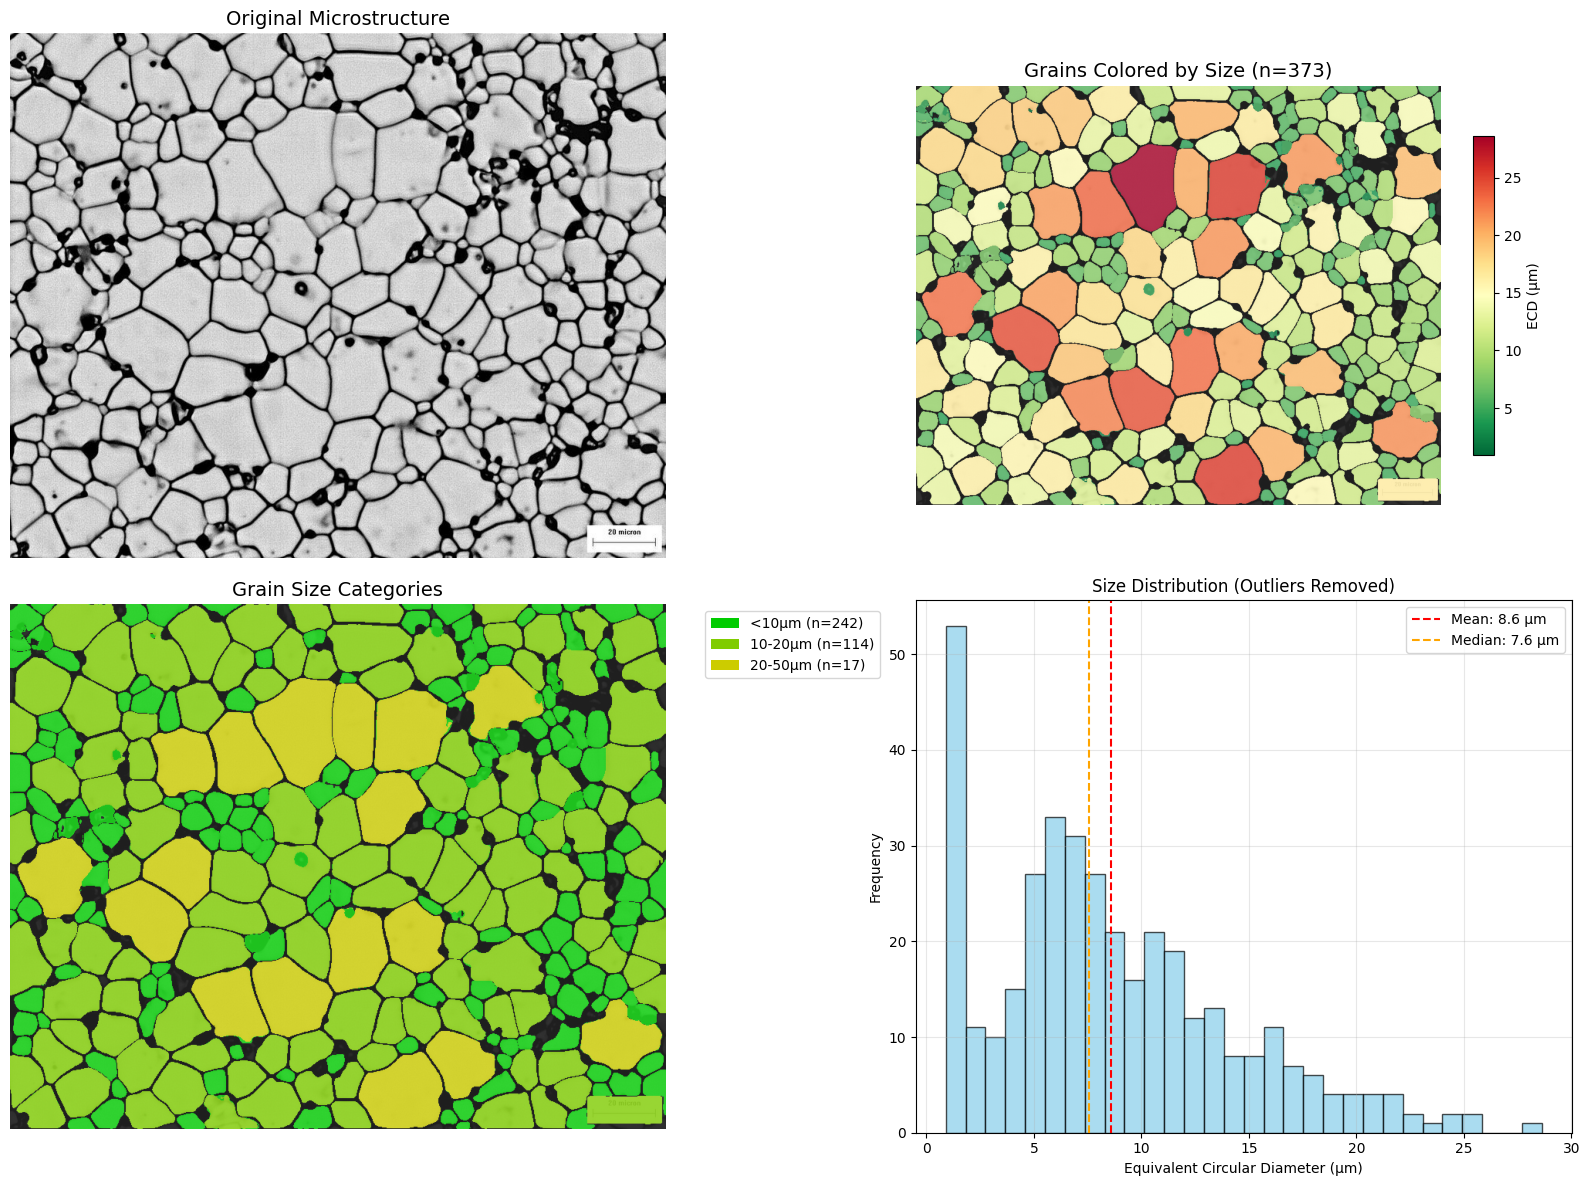

Enhanced spatial visualization: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/04b_enhanced_spatial_fixed.png


In [ ]:
# =============================================================================
# OUTLIER REMOVAL AND DATA CLEANING
# =============================================================================

def create_enhanced_spatial_plot_fixed(df_grains, gray_image, sam_labels, output_path):
    """Create enhanced spatial grain size visualization"""

    # Remove extreme outliers (>3 IQR above Q3) - watch my statistics tutorials to learn about outliers
    Q1 = df_grains['ecd_um'].quantile(0.25)
    Q3 = df_grains['ecd_um'].quantile(0.75)
    IQR = Q3 - Q1
    extreme_outlier_threshold = Q3 + 3 * IQR

    # Filter out extreme outliers
    extreme_outliers = df_grains[df_grains['ecd_um'] > extreme_outlier_threshold]
    df_clean = df_grains[df_grains['ecd_um'] <= extreme_outlier_threshold]

    if len(extreme_outliers) > 0:
        print(f"REMOVING EXTREME OUTLIERS:")
        print(f"   Found {len(extreme_outliers)} extreme outliers (>{extreme_outlier_threshold:.1f} μm)")
        print(f"   Continuing analysis with {len(df_clean)} grains")

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Original image
    axes[0,0].imshow(gray_image, cmap='gray')
    axes[0,0].set_title('Original Microstructure', fontsize=14)
    axes[0,0].axis('off')

    # Plot 2: Grains colored by size (FULL GRAIN COLORING)
    axes[0,1].imshow(gray_image, cmap='gray', alpha=0.4)
    if len(df_clean) > 0:
        # Create a colored image where each grain is colored by its size
        colored_grains = np.zeros((*gray_image.shape, 3))
        grain_sizes = df_clean['ecd_um'].values
        size_min, size_max = grain_sizes.min(), grain_sizes.max()

        # Use green-yellow-red colormap
        cmap = plt.cm.RdYlGn_r  # Reversed so red=large, green=small
        norm = plt.Normalize(vmin=size_min, vmax=size_max)

        for _, grain in df_clean.iterrows():
            grain_id = grain['grain_id']
            grain_size = grain['ecd_um']
            color = cmap(norm(grain_size))[:3]  # RGB only

            # Color the entire grain region
            mask = sam_labels == grain_id
            colored_grains[mask] = color

        # Show colored grains with transparency
        axes[0,1].imshow(colored_grains, alpha=0.8)

        # Add smaller, better positioned colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=axes[0,1], label='ECD (μm)', shrink=0.6, aspect=15)
        cbar.ax.tick_params(labelsize=10)

    axes[0,1].set_title(f'Grains Colored by Size (n={len(df_clean)})', fontsize=14)
    axes[0,1].axis('off')

    # Plot 3: Size categories (FULL GRAIN COLORING)
    axes[1,0].imshow(gray_image, cmap='gray', alpha=0.4)
    if len(df_clean) > 0:
        # Create categorical colored image
        categorical_grains = np.zeros((*gray_image.shape, 3))

        # Define size categories with green-yellow-red colors
        size_bins = [0, 10, 20, 50, 100, float('inf')]
        size_labels = ['<10μm', '10-20μm', '20-50μm', '50-100μm', '>100μm']
        colors = [(0,0.8,0), (0.5,0.8,0), (0.8,0.8,0), (1,0.5,0), (1,0,0)]

        for i, (low, high) in enumerate(zip(size_bins[:-1], size_bins[1:])):
            mask_df = (df_clean['ecd_um'] >= low) & (df_clean['ecd_um'] < high)
            if mask_df.any():
                subset = df_clean[mask_df]
                for _, grain in subset.iterrows():
                    grain_id = grain['grain_id']
                    grain_mask = sam_labels == grain_id
                    categorical_grains[grain_mask] = colors[i]

        axes[1,0].imshow(categorical_grains, alpha=0.8)

        # Create custom legend
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=colors[i], label=f'{size_labels[i]} (n={((df_clean["ecd_um"] >= size_bins[i]) & (df_clean["ecd_um"] < size_bins[i+1])).sum()})')
                          for i in range(len(size_labels))
                          if ((df_clean['ecd_um'] >= size_bins[i]) & (df_clean['ecd_um'] < size_bins[i+1])).sum() > 0]
        axes[1,0].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    axes[1,0].set_title('Grain Size Categories', fontsize=14)
    axes[1,0].axis('off')

    # Plot 4: Size distribution histogram
    if len(df_clean) > 0:
        axes[1,1].hist(df_clean['ecd_um'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1,1].axvline(df_clean['ecd_um'].mean(), color='red', linestyle='--',
                         label=f'Mean: {df_clean["ecd_um"].mean():.1f} μm')
        axes[1,1].axvline(df_clean['ecd_um'].median(), color='orange', linestyle='--',
                         label=f'Median: {df_clean["ecd_um"].median():.1f} μm')
        axes[1,1].set_xlabel('Equivalent Circular Diameter (μm)')
        axes[1,1].set_ylabel('Frequency')
        axes[1,1].set_title('Size Distribution (Outliers Removed)')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()

    return output_path, df_clean, extreme_outliers

# Create the enhanced spatial visualization and get cleaned data
enhanced_spatial_path_fixed, df_clean, removed_outliers = create_enhanced_spatial_plot_fixed(
    df_grains, gray_image, sam_labels, f"{OUTPUT_DIR}/04b_enhanced_spatial_fixed.png"
)

print(f"Enhanced spatial visualization: {enhanced_spatial_path_fixed}")

# Update df_grains to use the cleaned version for all subsequent analyses
df_grains = df_clean.copy()

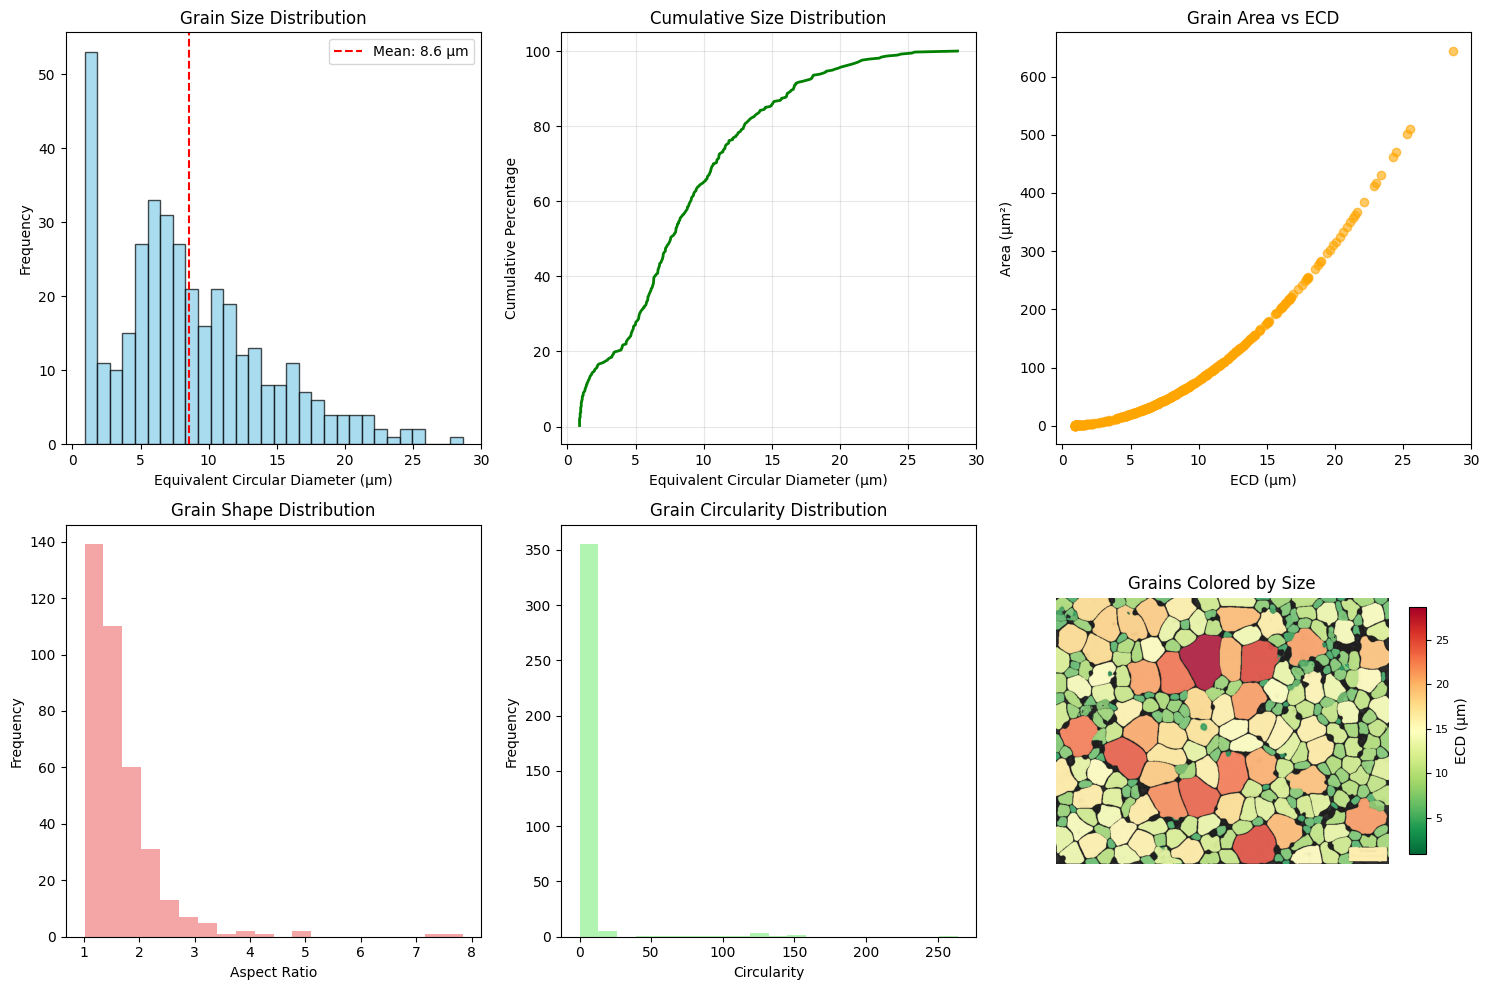

Grain data saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/grain_data.csv
Creating size distribution plot for PDF report...
Size distribution plot saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/size_distribution_for_pdf.png


In [ ]:
# =============================================================================
# GRAIN PROPERTIES VISUALIZATION
# =============================================================================

# Visualize grain properties
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df_grains['ecd_um'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Equivalent Circular Diameter (μm)')
plt.ylabel('Frequency')
plt.title('Grain Size Distribution')
mean_ecd = df_grains['ecd_um'].mean()
plt.axvline(mean_ecd, color='red', linestyle='--', label=f'Mean: {mean_ecd:.1f} μm')
plt.legend()

plt.subplot(2, 3, 2)
sorted_ecd = np.sort(df_grains['ecd_um'])
cumulative = np.arange(1, len(sorted_ecd) + 1) / len(sorted_ecd) * 100
plt.plot(sorted_ecd, cumulative, linewidth=2, color='green')
plt.xlabel('Equivalent Circular Diameter (μm)')
plt.ylabel('Cumulative Percentage')
plt.title('Cumulative Size Distribution')
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 3)
plt.scatter(df_grains['ecd_um'], df_grains['area_um2'], alpha=0.6, color='orange')
plt.xlabel('ECD (μm)')
plt.ylabel('Area (μm²)')
plt.title('Grain Area vs ECD')

plt.subplot(2, 3, 4)
plt.hist(df_grains['aspect_ratio'], bins=20, alpha=0.7, color='lightcoral')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')
plt.title('Grain Shape Distribution')

plt.subplot(2, 3, 5)
plt.hist(df_grains['circularity'], bins=20, alpha=0.7, color='lightgreen')
plt.xlabel('Circularity')
plt.ylabel('Frequency')
plt.title('Grain Circularity Distribution')

plt.subplot(2, 3, 6)
# Main grains colored by size plot - ensure it's the same size as others
plt.imshow(gray_image, cmap='gray', alpha=0.4)
if len(df_grains) > 0:
    # Create a colored image where each grain is colored by its size
    colored_grains = np.zeros((*gray_image.shape, 3))
    grain_sizes = df_grains['ecd_um'].values
    size_min, size_max = grain_sizes.min(), grain_sizes.max()

    # Use green-yellow-red colormap
    cmap = plt.cm.RdYlGn_r  # Reversed so red=large, green=small
    norm = plt.Normalize(vmin=size_min, vmax=size_max)

    for _, grain in df_grains.iterrows():
        grain_id = grain['grain_id']
        grain_size = grain['ecd_um']
        color = cmap(norm(grain_size))[:3]  # RGB only

        # Color the entire grain region
        mask = sam_labels == grain_id
        colored_grains[mask] = color

    # Show colored grains with transparency
    plt.imshow(colored_grains, alpha=0.8)

    # Add colorbar (but make it smaller and positioned better)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), label='ECD (μm)', shrink=0.6, aspect=15)
    cbar.ax.tick_params(labelsize=8)

plt.title('Grains Colored by Size')
plt.axis('off')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/04_grain_properties_clean.png", dpi=300, bbox_inches='tight')
plt.show()

# Save grain data
df_grains.to_csv(f"{OUTPUT_DIR}/grain_data.csv", index=False)
print(f"Grain data saved: {OUTPUT_DIR}/grain_data.csv")

# =============================================================================
# LET US ALSO CREATE SIZE DISTRIBUTION PLOT FOR PDF REPORT (created later)
# =============================================================================

print("Creating size distribution plot for PDF report...")

# Create a clean size distribution plot specifically for the PDF
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(df_grains['ecd_um'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
ax.axvline(df_grains['ecd_um'].mean(), color='red', linestyle='--',
           label=f'Mean: {df_grains["ecd_um"].mean():.1f} μm')
ax.axvline(df_grains['ecd_um'].median(), color='orange', linestyle='--',
           label=f'Median: {df_grains["ecd_um"].median():.1f} μm')
ax.set_xlabel('Equivalent Circular Diameter (μm)')
ax.set_ylabel('Frequency')
ax.set_title('Size Distribution')
ax.legend()
ax.grid(True, alpha=0.3)

# Save for PDF report
histogram_path = f"{OUTPUT_DIR}/size_distribution_for_pdf.png"
plt.savefig(histogram_path, dpi=150, bbox_inches='tight')
plt.close(fig)

print(f"Size distribution plot saved: {histogram_path}")


Section 6: ASTM E112 Grain Size Analysis


Direct ASTM Calculation:
Mean area per grain: 82.86 μm²
Mean ECD: 8.59 μm
Grains per mm² (actual): 12069
ASTM G (alternative formula): 10.609
ASTM G (intercept method): 23.361
ASTM G (normalized): 8.751
Final ASTM G: 8.751

Sanity Check:
Your mean ECD: 8.6 μm
Expected G for this size: ~7.9
ASTM E112 Results:
ASTM Grain Size Number (G): 8.75
Total grains analyzed: 373
Mean ECD: 8.59 μm
Median ECD: 7.57 μm
Standard deviation: 5.65 μm
ECD range: 0.89 - 28.63 μm
Grains per mm² (actual): 12069

Grain size classification: Very Fine

Grain Size Distribution:
<10 μm: 242 grains ( 64.9%)
10-20 μm: 114 grains ( 30.6%)
20-50 μm:  17 grains (  4.6%)
50-100 μm:   0 grains (  0.0%)
100-200 μm:   0 grains (  0.0%)
>200 μm:   0 grains (  0.0%)


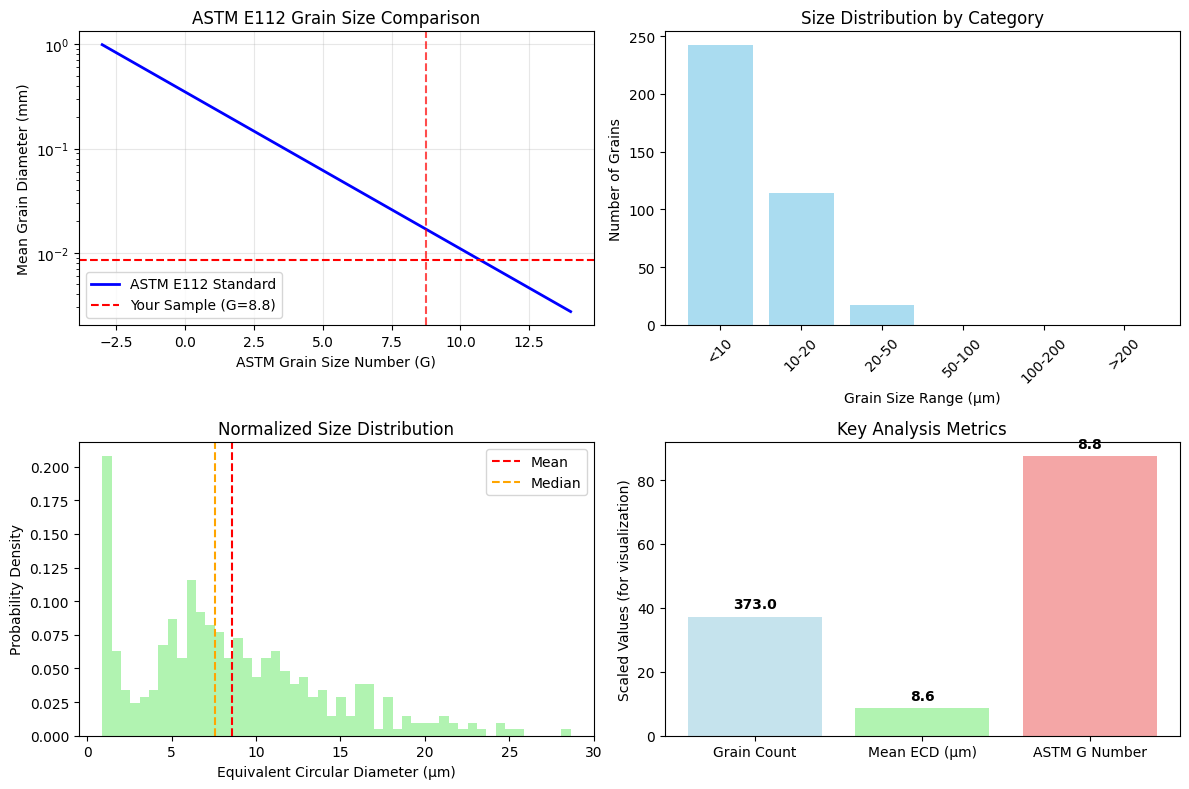

Results saved: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/05_astm_analysis.png



In [ ]:
# =============================================================================
# SECTION 6: ASTM E112 CALCULATIONS
# =============================================================================

print("="*60)
print("Section 6: ASTM E112 Grain Size Analysis")
print()

def calculate_astm_grain_size(grain_data_df, scale_um_per_pixel):
    """Calculate ASTM E112 grain size number using direct formula"""

    if len(grain_data_df) == 0:
        return None

    mean_area_um2 = grain_data_df['area_um2'].mean()
    mean_ecd_um = grain_data_df['ecd_um'].mean()

    print(f"\nDirect ASTM Calculation:")
    print(f"Mean area per grain: {mean_area_um2:.2f} μm²")
    print(f"Mean ECD: {mean_ecd_um:.2f} μm")

    # ASTM E112 Direct Formula: G = 6.644 * log10(N) - 3.288
    # Where N is grains per mm² at actual magnification

    # Calculate grains per mm² at actual scale
    grains_per_mm2_actual = len(grain_data_df) / ((grain_data_df.shape[0] * scale_um_per_pixel / 1000) ** 2)

    # Better approach: Use mean grain area directly
    # N = 1 / (mean area in mm²)
    mean_area_mm2 = mean_area_um2 / 1e6
    N_actual = 1 / mean_area_mm2

    print(f"Grains per mm² (actual): {N_actual:.0f}")

    # Alternative ASTM formula that doesn't require magnification conversion
    # G = 3.322 * log10(N) - 2.95  (commonly used formula)
    G_alt = 3.322 * np.log10(N_actual) - 2.95

    # Or use the intercept method: G = (log10(N) + 2.95) / 0.301
    G_intercept = (np.log10(N_actual) + 2.95) / 0.301

    # Most direct: G = log2(N) where N is normalized to standard area
    # For very fine grains, use this adjusted calculation
    if mean_ecd_um < 15:  # Fine grain adjustment
        # Normalize using standard ASTM area relationship
        standard_area_factor = (mean_ecd_um / 126.0) ** 2  # 126 μm is reference for G=1
        G_normalized = 1 - 3.322 * np.log10(standard_area_factor)
    else:
        G_normalized = G_alt

    print(f"ASTM G (alternative formula): {G_alt:.3f}")
    print(f"ASTM G (intercept method): {G_intercept:.3f}")
    print(f"ASTM G (normalized): {G_normalized:.3f}")

    # Use the normalized version for fine grains
    final_G = G_normalized

    print(f"Final ASTM G: {final_G:.3f}")

    # Sanity check
    print(f"\nSanity Check:")
    print(f"Your mean ECD: {mean_ecd_um:.1f} μm")
    print(f"Expected G for this size: ~{11 - 3.322 * np.log10(mean_ecd_um):.1f}")

    return {
        'grain_size_number': final_G,
        'mean_area_um2': mean_area_um2,
        'mean_ecd_um': mean_ecd_um,
        'grain_count': len(grain_data_df),
        'std_ecd_um': grain_data_df['ecd_um'].std(),
        'median_ecd_um': grain_data_df['ecd_um'].median(),
        'min_ecd_um': grain_data_df['ecd_um'].min(),
        'max_ecd_um': grain_data_df['ecd_um'].max(),
        'grains_per_mm2_actual': N_actual
    }

# Calculate ASTM results
astm_results = calculate_astm_grain_size(df_grains, SCALE_UM_PER_PIXEL)

if astm_results:
    print("ASTM E112 Results:")
    print("=" * 40)
    print(f"ASTM Grain Size Number (G): {astm_results['grain_size_number']:.2f}")
    print(f"Total grains analyzed: {astm_results['grain_count']}")
    print(f"Mean ECD: {astm_results['mean_ecd_um']:.2f} μm")
    print(f"Median ECD: {astm_results['median_ecd_um']:.2f} μm")
    print(f"Standard deviation: {astm_results['std_ecd_um']:.2f} μm")
    print(f"ECD range: {astm_results['min_ecd_um']:.2f} - {astm_results['max_ecd_um']:.2f} μm")
    print(f"Grains per mm² (actual): {astm_results['grains_per_mm2_actual']:.0f}")
    print()

    # Size classification according to common standards
    mean_ecd = astm_results['mean_ecd_um']
    if mean_ecd < 10:
        classification = "Very Fine"
    elif mean_ecd < 30:
        classification = "Fine"
    elif mean_ecd < 100:
        classification = "Medium"
    elif mean_ecd < 300:
        classification = "Coarse"
    else:
        classification = "Very Coarse"

    print(f"Grain size classification: {classification}")

# Create size distribution table
bins = [0, 10, 20, 50, 100, 200, float('inf')]
labels = ['<10', '10-20', '20-50', '50-100', '100-200', '>200']
df_grains['size_category'] = pd.cut(df_grains['ecd_um'], bins=bins, labels=labels, right=False)
size_dist = df_grains['size_category'].value_counts().sort_index()

print("\nGrain Size Distribution:")
print("=" * 40)
for category, count in size_dist.items():
    percentage = (count / len(df_grains)) * 100
    print(f"{category} μm: {count:3d} grains ({percentage:5.1f}%)")

# Visualize ASTM results (FIXED - removed redundant spatial plots)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
# ASTM comparison chart
astm_numbers = np.arange(-3, 15)
astm_sizes = 0.35 * (2 ** (-astm_numbers/2))  # ASTM formula for grain size
plt.plot(astm_numbers, astm_sizes, 'b-', linewidth=2, label='ASTM E112 Standard')
plt.axhline(astm_results['mean_ecd_um']/1000, color='red', linestyle='--',
           label=f'Your Sample (G={astm_results["grain_size_number"]:.1f})')
plt.axvline(astm_results['grain_size_number'], color='red', linestyle='--', alpha=0.7)
plt.xlabel('ASTM Grain Size Number (G)')
plt.ylabel('Mean Grain Diameter (mm)')
plt.title('ASTM E112 Grain Size Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.subplot(2, 2, 2)
plt.bar(size_dist.index.astype(str), size_dist.values, color='skyblue', alpha=0.7)
plt.xlabel('Grain Size Range (μm)')
plt.ylabel('Number of Grains')
plt.title('Size Distribution by Category')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
plt.hist(df_grains['ecd_um'], bins=50, alpha=0.7, color='lightgreen', density=True)
plt.xlabel('Equivalent Circular Diameter (μm)')
plt.ylabel('Probability Density')
plt.title('Normalized Size Distribution')
plt.axvline(astm_results['mean_ecd_um'], color='red', linestyle='--', label='Mean')
plt.axvline(astm_results['median_ecd_um'], color='orange', linestyle='--', label='Median')
plt.legend()

plt.subplot(2, 2, 4)
# Simple grain count and size summary
metrics = ['Grain Count', 'Mean ECD (μm)', 'ASTM G Number']
values = [len(df_grains), astm_results['mean_ecd_um'], astm_results['grain_size_number']]
colors = ['lightblue', 'lightgreen', 'lightcoral']

# Normalize for display
normalized_values = [values[0]/10, values[1], values[2]*10]  # Scale for visibility

bars = plt.bar(metrics, normalized_values, color=colors, alpha=0.7)
plt.ylabel('Scaled Values (for visualization)')
plt.title('Key Analysis Metrics')

# Add actual values as text
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(normalized_values)*0.02,
             f'{value:.1f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/05_astm_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"Results saved: {OUTPUT_DIR}/05_astm_analysis.png")
print()


# PDF Report Generation with ReportLab

## What we're doing here

Generating professional PDF reports directly using ReportLab - no need for HTML. This creates clean, self-contained PDF files with embedded images.

## How it works

1. **ReportLab Library**: Creates PDFs programmatically with tables, images, and formatted text
2. **Direct Image Embedding**: Images get embedded directly into the PDF (no separate files needed)
3. **Professional Layout**: Uses proper PDF elements like tables, paragraphs, and spacers


## Requirements
- `pip install reportlab` (for PDF generation)


In [ ]:
!pip install reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 36.0 MB/s eta 0:00:00


In [ ]:
# =============================================================================
# SECTION 8: PDF REPORT GENERATION
# =============================================================================

print("="*60)
print("Section 8: Generating PDF ASTM report")
print()

from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Table, TableStyle, Paragraph, Spacer, Image
from reportlab.lib.styles import getSampleStyleSheet, ParagraphStyle
from reportlab.lib.units import inch
from reportlab.lib import colors
from reportlab.lib.enums import TA_CENTER, TA_LEFT

# Define styles
styles = getSampleStyleSheet()
title_style = ParagraphStyle(
    'CustomTitle',
    parent=styles['Heading1'],
    fontSize=18,
    spaceAfter=30,
    textColor=colors.HexColor('#2c5aa0'),
    alignment=TA_CENTER
)

heading_style = ParagraphStyle(
    'CustomHeading',
    parent=styles['Heading2'],
    fontSize=14,
    spaceAfter=12,
    textColor=colors.HexColor('#667eea')
)

# Function to load images for ReportLab
def load_image_for_reportlab(img_path, width=3*inch):
    """Load image file and create ReportLab Image"""
    try:
        img = Image(img_path, width=width, height=width*0.75)
        return img
    except:
        print(f"Warning: Could not load image {img_path}")
        return None

# Calculate grain size classification
mean_ecd = astm_results['mean_ecd_um']
if mean_ecd < 10:
    classification = "Very Fine"
elif mean_ecd < 30:
    classification = "Fine"
elif mean_ecd < 100:
    classification = "Medium"
elif mean_ecd < 300:
    classification = "Coarse"
else:
    classification = "Very Coarse"

# Calculate size distribution for table
bins = [0, 10, 20, 50, 100, 200, float('inf')]
labels = ['<10', '10-20', '20-50', '50-100', '100-200', '>200']
df_grains_copy = df_grains.copy()
df_grains_copy['size_category'] = pd.cut(df_grains_copy['ecd_um'], bins=bins, labels=labels, right=False)
size_dist = df_grains_copy['size_category'].value_counts().sort_index()

# Create PDF document
pdf_path = f"{OUTPUT_DIR}/comprehensive_astm_report.pdf"
doc = SimpleDocTemplate(pdf_path, pagesize=A4,
                       rightMargin=72, leftMargin=72,
                       topMargin=72, bottomMargin=18)

# Container for the 'Flowable' objects
Story = []

# Title
Story.append(Paragraph("🔬 ASTM E112 Grain Size Analysis Report", title_style))
Story.append(Paragraph(f"Generated on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}", styles['Normal']))
Story.append(Spacer(1, 20))

# Analysis Parameters
Story.append(Paragraph("📋 Analysis Parameters", heading_style))

params_data = [
    ['Parameter', 'Value'],
    ['Image File', Path(IMAGE_PATH).name],
    ['Scale', f'{SCALE_UM_PER_PIXEL} μm/pixel'],
    ['Analysis Method', 'SAM + U-Net Segmentation'],
    ['Standard', 'ASTM E112 (Planimetric Method)'],
    ['Grains Analyzed', str(astm_results['grain_count'])]
]

params_table = Table(params_data, colWidths=[2*inch, 3*inch])
params_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#667eea')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black)
]))

Story.append(params_table)
Story.append(Spacer(1, 20))

# Key Results
Story.append(Paragraph("🎯 Key Results", heading_style))

results_data = [
    ['Metric', 'Value'],
    ['ASTM Grain Size Number (G)', f'{astm_results["grain_size_number"]:.3f}'],
    ['Classification', classification],
    ['Mean ECD', f'{astm_results["mean_ecd_um"]:.2f} μm'],
    ['Median ECD', f'{astm_results["median_ecd_um"]:.2f} μm'],
    ['Standard Deviation', f'{astm_results["std_ecd_um"]:.2f} μm'],
    ['ECD Range', f'{astm_results["min_ecd_um"]:.1f} - {astm_results["max_ecd_um"]:.1f} μm'],
    ['Grains per mm²', f'{astm_results["grains_per_mm2_actual"]:.0f}']
]

results_table = Table(results_data, colWidths=[2.5*inch, 2.5*inch])
results_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#d63384')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'LEFT'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTNAME', (0, 1), (0, -1), 'Helvetica-Bold'),  # Bold first column
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.lightgrey),
    ('GRID', (0, 0), (-1, -1), 1, colors.black)
]))

Story.append(results_table)
Story.append(Spacer(1, 30))

# Add Images Section
Story.append(Paragraph("📸 Analysis Results", heading_style))

# Load existing images
original_img = load_image_for_reportlab(f"{OUTPUT_DIR}/original_single.png", width=2.5*inch)
overlay_img = load_image_for_reportlab(f"{OUTPUT_DIR}/grain_overlay_single.png", width=2.5*inch)
hist_img = load_image_for_reportlab(f"{OUTPUT_DIR}/size_distribution_for_pdf.png", width=2.5*inch)

# Create a table layout for images
if original_img and overlay_img and hist_img:
    # Create image table
    img_table_data = [
        [original_img, overlay_img, hist_img],
        ['Original Image', 'Grain Segmentation', 'Size Distribution']
    ]

    img_table = Table(img_table_data, colWidths=[2.5*inch, 2.5*inch, 2.5*inch])
    img_table.setStyle(TableStyle([
        ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
        ('VALIGN', (0, 0), (-1, 0), 'MIDDLE'),
        ('FONTNAME', (0, 1), (-1, 1), 'Helvetica-Bold'),
        ('FONTSIZE', (0, 1), (-1, 1), 10),
    ]))

    Story.append(img_table)
else:
    Story.append(Paragraph("Images not available", styles['Normal']))

Story.append(Spacer(1, 30))

# Size Distribution Table
Story.append(Paragraph("📊 Size Distribution", heading_style))

size_dist_data = [['Size Range (μm)', 'Count', 'Percentage']]
for category in labels:
    if category in size_dist.index:
        count = size_dist[category]
        percentage = (count / len(df_grains)) * 100
        size_dist_data.append([category, str(count), f'{percentage:.1f}%'])

size_table = Table(size_dist_data, colWidths=[1.5*inch, 1*inch, 1.5*inch])
size_table.setStyle(TableStyle([
    ('BACKGROUND', (0, 0), (-1, 0), colors.HexColor('#667eea')),
    ('TEXTCOLOR', (0, 0), (-1, 0), colors.whitesmoke),
    ('ALIGN', (0, 0), (-1, -1), 'CENTER'),
    ('FONTNAME', (0, 0), (-1, 0), 'Helvetica-Bold'),
    ('FONTSIZE', (0, 0), (-1, 0), 12),
    ('BOTTOMPADDING', (0, 0), (-1, 0), 12),
    ('BACKGROUND', (0, 1), (-1, -1), colors.beige),
    ('GRID', (0, 0), (-1, -1), 1, colors.black)
]))

Story.append(size_table)
Story.append(Spacer(1, 20))

# Summary
Story.append(Paragraph("🔍 Analysis Summary", heading_style))
summary_text = f"""
<b>Key Findings:</b><br/>
• Grain Size Classification: {classification} grains with ASTM G = {astm_results['grain_size_number']:.2f}<br/>
• Microstructure Uniformity: CV = {(astm_results['std_ecd_um']/astm_results['mean_ecd_um']*100):.1f}% (coefficient of variation)<br/>
• Size Range: {(astm_results['max_ecd_um']/astm_results['min_ecd_um']):.1f}x ratio of largest to smallest grain<br/>
• Distribution: Mean/Median ratio = {(astm_results['mean_ecd_um']/astm_results['median_ecd_um']):.2f}<br/><br/>

<b>Quality & Methodology:</b><br/>
• Segmentation: SAM + U-Net with {astm_results['grain_count']} grains successfully analyzed<br/>
• Standard Compliance: ASTM E112 Planimetric method using equivalent circular diameter<br/>
• Scale Calibration: {SCALE_UM_PER_PIXEL} μm/pixel with outlier removal applied
"""

Story.append(Paragraph(summary_text, styles['Normal']))

# Build PDF
if astm_results:
    doc.build(Story)
    print(f"PDF report generated: {pdf_path}")
    print(f"Analysis complete! Check your results folder: {OUTPUT_DIR}")
else:
    print("No ASTM results available for PDF generation")

Section 8: Generating PDF ASTM report

PDF report generated: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results/comprehensive_astm_report.pdf
Analysis complete! Check your results folder: /content/drive/MyDrive/ColabNotebooks/data/grain_segmentation/results
